# Projet 7 Datascientist: Implémentez un modèle de scoring

## Problématique
- L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

- De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

- Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

- Pour cette mission nous sommes incités à sélectionner un kernel Kaggle pour nous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. ensuite analyser ce kernel et l’adapter pour nous assurer qu’il répond aux besoins de notre mission.

- Le Kernel que j'ai utilisé et adapté ce trouve sur cette adresse: 
https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

In [3]:
import matplotlib.image as img
import matplotlib.pyplot as plt

## Shema du Dataset

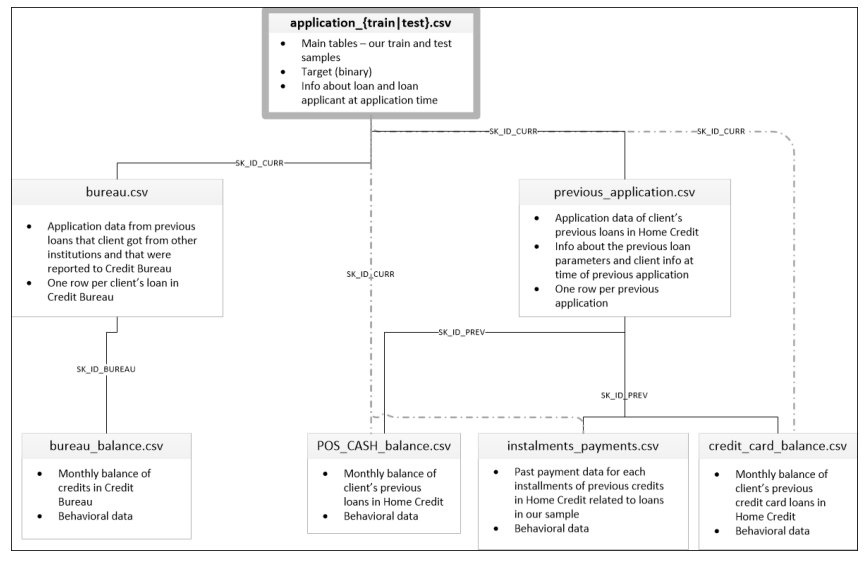

In [5]:
image = img.imread('https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png')
plt.figure(figsize=(17, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()

## Importer les librairies

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import sklearn
from contextlib import contextmanager
from collections import Counter
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from urllib.request import urlretrieve
from IPython.display import display, HTML

In [3]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [4]:
# Importing the SimpleImputer class
from sklearn.impute import SimpleImputer

## Feature engineering:
- Comme mentionné précedemment je me suis inspirée d'un Kernel pour la partie feature engineering:
- 1/Télecharger les données
- 2/Concaténer les différents tableaux
- 3/Créer de nouvelles features


In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv("application_train.csv",encoding="utf-8", nrows= num_rows)
    test_df = pd.read_csv("application_test.csv",encoding="utf-8", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv("bureau.csv",encoding="utf-8", nrows = num_rows)
    bb = pd.read_csv("bureau_balance.csv",encoding="utf-8", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv("previous_application.csv",encoding="utf-8", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [10]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv("POS_CASH_balance.csv",encoding="utf-8", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [11]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv("installments_payments.csv",encoding="utf-8", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [12]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("credit_card_balance.csv",encoding="utf-8", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [13]:
debug = False

In [14]:
num_rows = 100000# if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()


Train samples: 100000, test samples: 48744
Bureau df shape: (23121, 113)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (79977, 247)
Process previous_applications - done in 3s
Pos-cash balance df shape: (77469, 15)
Process POS-CASH balance - done in 3s
Installments payments df shape: (48591, 26)
Process installments payments - done in 2s
Credit card balance df shape: (53383, 131)
Process credit card balance - done in 5s


### Fichier data obtenu après feature engineering

In [15]:
df.head(5)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Enumerer les colonnes
for idx,column in enumerate(df.columns):
    print(idx,column)

0 index
1 SK_ID_CURR
2 TARGET
3 CODE_GENDER
4 FLAG_OWN_CAR
5 FLAG_OWN_REALTY
6 CNT_CHILDREN
7 AMT_INCOME_TOTAL
8 AMT_CREDIT
9 AMT_ANNUITY
10 AMT_GOODS_PRICE
11 REGION_POPULATION_RELATIVE
12 DAYS_BIRTH
13 DAYS_EMPLOYED
14 DAYS_REGISTRATION
15 DAYS_ID_PUBLISH
16 OWN_CAR_AGE
17 FLAG_MOBIL
18 FLAG_EMP_PHONE
19 FLAG_WORK_PHONE
20 FLAG_CONT_MOBILE
21 FLAG_PHONE
22 FLAG_EMAIL
23 CNT_FAM_MEMBERS
24 REGION_RATING_CLIENT
25 REGION_RATING_CLIENT_W_CITY
26 HOUR_APPR_PROCESS_START
27 REG_REGION_NOT_LIVE_REGION
28 REG_REGION_NOT_WORK_REGION
29 LIVE_REGION_NOT_WORK_REGION
30 REG_CITY_NOT_LIVE_CITY
31 REG_CITY_NOT_WORK_CITY
32 LIVE_CITY_NOT_WORK_CITY
33 EXT_SOURCE_1
34 EXT_SOURCE_2
35 EXT_SOURCE_3
36 APARTMENTS_AVG
37 BASEMENTAREA_AVG
38 YEARS_BEGINEXPLUATATION_AVG
39 YEARS_BUILD_AVG
40 COMMONAREA_AVG
41 ELEVATORS_AVG
42 ENTRANCES_AVG
43 FLOORSMAX_AVG
44 FLOORSMIN_AVG
45 LANDAREA_AVG
46 LIVINGAPARTMENTS_AVG
47 LIVINGAREA_AVG
48 NONLIVINGAPARTMENTS_AVG
49 NONLIVINGAREA_AVG
50 APARTMENTS_MODE
51 BASEMEN

543 PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN
544 PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN
545 PREV_PRODUCT_COMBINATION_POS other with interest_MEAN
546 PREV_PRODUCT_COMBINATION_POS others without interest_MEAN
547 PREV_PRODUCT_COMBINATION_nan_MEAN
548 APPROVED_AMT_ANNUITY_MIN
549 APPROVED_AMT_ANNUITY_MAX
550 APPROVED_AMT_ANNUITY_MEAN
551 APPROVED_AMT_APPLICATION_MIN
552 APPROVED_AMT_APPLICATION_MAX
553 APPROVED_AMT_APPLICATION_MEAN
554 APPROVED_AMT_CREDIT_MIN
555 APPROVED_AMT_CREDIT_MAX
556 APPROVED_AMT_CREDIT_MEAN
557 APPROVED_APP_CREDIT_PERC_MIN
558 APPROVED_APP_CREDIT_PERC_MAX
559 APPROVED_APP_CREDIT_PERC_MEAN
560 APPROVED_APP_CREDIT_PERC_VAR
561 APPROVED_AMT_DOWN_PAYMENT_MIN
562 APPROVED_AMT_DOWN_PAYMENT_MAX
563 APPROVED_AMT_DOWN_PAYMENT_MEAN
564 APPROVED_AMT_GOODS_PRICE_MIN
565 APPROVED_AMT_GOODS_PRICE_MAX
566 APPROVED_AMT_GOODS_PRICE_MEAN
567 APPROVED_HOUR_APPR_PROCESS_START_MIN
568 APPROVED_HOUR_APPR_PROCESS_START_MAX
569 APPROVED_HOUR_APPR_PROCESS

In [17]:
df.shape

(148741, 780)

###  supprimer les lignes dont « TARGET »  NAN


In [18]:
df2 = df[df['TARGET'].notna()]
df2.shape

(99997, 780)

In [19]:
df2=df2.drop(["index"],1)

### supprimer les colonnes avec +60% de valeurs manquantes 

In [20]:
#supprimer les colonnes avec +60% de valeurs manquantes 
for c in df2.columns:
    if  (df2[c].isna().sum() / df2.shape[0]) > 0.6:
        df2.drop(c,1,inplace=True)
 

In [21]:
df2.shape

(99997, 255)

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99997 entries, 0 to 99999
Columns: 255 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(80), int64(42), uint8(133)
memory usage: 106.5 MB


## Données désequilibrées:
- Nous sommes en présence de données désequilibées, cela se voit clairement sur le count plot de la "target" il y a environ 10 fois plus de TARGET=0 que de TARGET=1. IL faut donc penser à remédier au problème du "imbalanced data"

0.0    91904
1.0     8093
Name: TARGET, dtype: int64


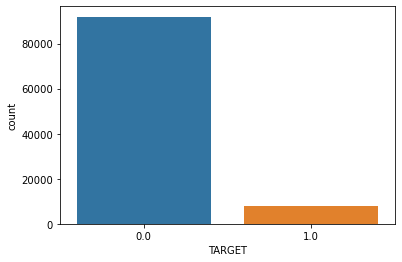

In [23]:
ax = sns.countplot(x="TARGET", data=df2)
print(df2["TARGET"].value_counts())

### Nettoyage des données:
- Dans cette partie je procède à la correction du dtype de mes colonnes


In [24]:
uint8 = df2.loc[:, df2.dtypes == np.uint8]
uint8

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99996,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
99997,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
99998,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [25]:
int64 = df2.loc[:, df2.dtypes == np.int64]
int64.head(42)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,0,0,0,0,-9461,-2120,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,100003,1,0,1,0,-16765,-291,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,0,0,-19046,-2531,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,1,0,0,0,-19005,-2437,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,0,-19932,-3458,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,0,0,0,-16941,-477,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,100009,1,1,0,1,-13778,-619,1,1,0,...,0,0,1,0,0,0,0,0,0,0
7,100010,0,1,0,0,-18850,-2379,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,100011,1,0,0,0,-20099,-3514,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,100012,0,0,0,0,-14469,-3992,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
int64.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [27]:
int64_2=df2[['SK_ID_CURR','CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','FLAG_MOBIL',        
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL',  'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]
int64_2

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,100003,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,100006,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,216086,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,216087,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,216088,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,216089,1,1,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
pd.set_option('display.max_rows', None)

In [29]:
n2 = uint8.nunique(axis=0)
  
print("No.of.unique values in each column :\n", n2)

No.of.unique values in each column :
 NAME_CONTRACT_TYPE_Cash loans                        2
NAME_CONTRACT_TYPE_Revolving loans                   2
NAME_TYPE_SUITE_Children                             2
NAME_TYPE_SUITE_Family                               2
NAME_TYPE_SUITE_Group of people                      2
NAME_TYPE_SUITE_Other_A                              2
NAME_TYPE_SUITE_Other_B                              2
NAME_TYPE_SUITE_Spouse, partner                      2
NAME_TYPE_SUITE_Unaccompanied                        2
NAME_INCOME_TYPE_Businessman                         2
NAME_INCOME_TYPE_Commercial associate                2
NAME_INCOME_TYPE_Maternity leave                     2
NAME_INCOME_TYPE_Pensioner                           2
NAME_INCOME_TYPE_State servant                       2
NAME_INCOME_TYPE_Student                             2
NAME_INCOME_TYPE_Unemployed                          2
NAME_INCOME_TYPE_Working                             2
NAME_EDUCATION_TYPE_Academi

In [30]:
df2.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,98356.995,98356.995,98356.995,98356.995,98356.995,98356.995,-690.0,-690.0,-690.0,1.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,2717.910,5435.820,1834.290,3601.530,2717.910,5435.820,-1654.0,-1944.0,-3888.0,2.0


In [31]:
float64 = df2.loc[:, df2.dtypes == np.float64]
float64.head(42)

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,1.0,202500.000,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,1.0,0.083037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,270000.000,1293502.5,35698.5,1129500.0,0.003541,-1188.0,-1186.0,2.0,0.311267,...,98356.99500,98356.995,98356.995,98356.995,98356.99500,98356.995,-690.0,-690.000000,-690.0,1.0
2,0.0,67500.000,135000.0,6750.0,135000.0,0.010032,-225.0,-4260.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,135000.000,312682.5,29686.5,297000.0,0.008019,-3039.0,-9833.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,121500.000,513000.0,21865.5,513000.0,0.028663,-3038.0,-4311.0,1.0,NaN,...,2717.91000,5435.820,1834.290,3601.530,2717.91000,5435.820,-1654.0,-1944.000000,-3888.0,2.0
5,0.0,99000.000,490495.5,27517.5,454500.0,0.035792,-1588.0,-4970.0,2.0,NaN,...,14058.13500,42174.405,12144.285,17885.835,14058.13500,42174.405,-190.0,-1488.000000,-4464.0,3.0
6,0.0,171000.000,1560726.0,41301.0,1395000.0,0.035792,-3130.0,-1213.0,3.0,0.774761,...,7853.59125,31414.365,6160.500,8996.760,7853.59125,31414.365,-194.0,-1010.500000,-4042.0,4.0
7,0.0,360000.000,1530000.0,42075.0,1530000.0,0.003122,-449.0,-4597.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,112500.000,1019610.0,33826.5,913500.0,0.018634,NaN,-7427.0,2.0,0.587334,...,14588.55000,14588.550,449.685,449.685,449.68500,449.685,-1189.0,-1189.000000,-1189.0,1.0
9,0.0,135000.000,405000.0,20250.0,405000.0,0.019689,-2019.0,-14437.0,1.0,NaN,...,8150.19750,16300.395,5242.860,11057.535,8150.19750,16300.395,-307.0,-367.500000,-735.0,2.0


In [32]:
n3 = float64.nunique(axis=0)
  
print("No.of.unique values in each column :\n", n3)

No.of.unique values in each column :
 TARGET                                       2
AMT_INCOME_TOTAL                          1212
AMT_CREDIT                                4162
AMT_ANNUITY                              10773
AMT_GOODS_PRICE                            623
REGION_POPULATION_RELATIVE                  80
DAYS_EMPLOYED                             9869
DAYS_REGISTRATION                        14101
CNT_FAM_MEMBERS                             12
EXT_SOURCE_1                             41488
EXT_SOURCE_2                             65757
EXT_SOURCE_3                               765
APARTMENTS_AVG                            1848
BASEMENTAREA_AVG                          3211
YEARS_BEGINEXPLUATATION_AVG                220
ELEVATORS_AVG                              207
ENTRANCES_AVG                              232
FLOORSMAX_AVG                              300
LANDAREA_AVG                              2933
LIVINGAREA_AVG                            4353
NONLIVINGAREA_AVG     

In [33]:
R=['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','NAME_CONTRACT_TYPE_Cash loans', 
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family',
    'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
    'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman',
    'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 
    'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed',
    'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff', 'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Business Entity Type 3', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Culture', 'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing', 'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12', 'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4', 'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8', 'ORGANIZATION_TYPE_Industry: type 9', 'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Military', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Postal', 'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_School', 'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1', 'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7', 'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 3', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University', 'ORGANIZATION_TYPE_XNA', 'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account', 'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes']
R

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_

In [34]:
print(uint8.columns.tolist())


['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HO

In [35]:
df3=df2.copy()

In [36]:
df3[R] = df3[R].astype('category')


In [37]:
df3[['SK_ID_CURR']] = df3[['SK_ID_CURR']].astype('object')


In [38]:
df3[['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START']] = df3[['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START']].astype('float64')


In [39]:
df3.dtypes

SK_ID_CURR                                             object
TARGET                                                float64
CODE_GENDER                                          category
FLAG_OWN_CAR                                         category
FLAG_OWN_REALTY                                      category
CNT_CHILDREN                                          float64
AMT_INCOME_TOTAL                                      float64
AMT_CREDIT                                            float64
AMT_ANNUITY                                           float64
AMT_GOODS_PRICE                                       float64
REGION_POPULATION_RELATIVE                            float64
DAYS_BIRTH                                            float64
DAYS_EMPLOYED                                         float64
DAYS_REGISTRATION                                     float64
DAYS_ID_PUBLISH                                       float64
FLAG_MOBIL                                           category
FLAG_EMP

In [40]:
X = df3.drop('TARGET', axis=1)
y = df3['TARGET']

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99997 entries, 0 to 99999
Columns: 254 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: category(168), float64(85), object(1)
memory usage: 84.4+ MB


### Remplacer les valeurs infinies par des NAN

In [42]:
Xnum = X.loc[:, X.dtypes == np.float64]

In [43]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)

### Spliter les données en set d'apprentissage et set de test

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = \
train_test_split(X,y,test_size=0.3,random_state=12)

### Imputer les valeurs manquantes par la méthode SimpleImputer( strategy ='mean')

In [45]:
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')

In [46]:
columns= X_train.columns

In [47]:
X_train[columns] = imputer.fit_transform(X_train[columns],y_train)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [48]:
X_test[columns] = imputer.transform(X_test)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [49]:
X_train.shape

(69997, 254)

In [50]:
X_train=X_train.drop(["SK_ID_CURR"],1)

In [51]:
X_test=X_test.drop(["SK_ID_CURR"],1)

In [52]:
import warnings
warnings.filterwarnings('ignore')

# simulation et comparaison des modèles:
- Comparaison de 4 modèles à un algorithme de base "DummyClassifier"; à ces modèles j'ai appliqué un "class_weight" pour traiter les classes non équilibrées/
- les modèles utilisés sont:
- XGBClassifier(scale_pos_weight=9)
- DecisionTreeClassifier(class_weight='balanced')
- RandomForestClassifier(class_weight='balanced')
- BalancedRandomForestClassifier()

In [53]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score),
           'AUC':make_scorer(roc_auc_score),
           'f1_score':make_scorer(f1_score)}

# Import required libraries for machine learning classifiers
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate the machine learning classifiers

xgb_model = XGBClassifier(scale_pos_weight=9)
dtr_model = DecisionTreeClassifier(class_weight='balanced')
rfc_model = RandomForestClassifier(class_weight='balanced')
brfc_model = BalancedRandomForestClassifier()
dummy_model = DummyClassifier()


In [54]:
# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    xgb = cross_validate(xgb_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    brfc = cross_validate(brfc_model, X, y, cv=folds, scoring=scoring)
    dummy = cross_validate(dummy_model, X, y, cv=folds, scoring=scoring)
    
    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'XGB Classifier':[xgb['test_accuracy'].mean(),
                                                               xgb['test_precision'].mean(),
                                                               xgb['test_recall'].mean(),
                                                               xgb['test_AUC'].mean(),
                                                               xgb['test_f1_score'].mean()],
                                        
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_AUC'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                        
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_AUC'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Balanced Random Forest':[brfc['test_accuracy'].mean(),
                                                       brfc['test_precision'].mean(),
                                                       brfc['test_recall'].mean(),
                                                       brfc['test_AUC'].mean(),
                                                       brfc['test_f1_score'].mean()],
                                       
                                      
                                       'Dummy Classifier':[dummy['test_accuracy'].mean(),
                                                           dummy['test_precision'].mean(),
                                                           dummy['test_recall'].mean(),
                                                           dummy['test_AUC'].mean(),
                                                           dummy['test_f1_score'].mean()]},
                                       
                                      
                                      index=['Accuracy', 'Precision', 'Recall','AUC', 'F1 Score'])
    
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [55]:
# Run models_evaluation function
models_evaluation(X_train, y_train, 5)

[00:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,XGB Classifier,Decision Tree,Random Forest,Balanced Random Forest,Dummy Classifier
Accuracy,0.823578,0.855251,0.919268,0.691215,0.852337
Precision,0.204750,0.149871,0.216667,0.155995,0.082654
Recall,0.411911,0.170330,0.000709,0.641792,0.082593
AUC,0.635790,0.542814,0.500253,0.668670,0.501206
F1 Score,0.273505,0.159403,0.001412,0.250977,0.082615


- En terme de AUC, On remarque d'abord que nos modèles sont plus performants que le modèle de base "Dummy Regressor" (Random Forest)
- Les meilleures performances sont celles du modèle "Balanced Random Forest" 

Modèle à Optimiser: 
- "Balanced Random Forest" 

## Fonction de coût métier – optimisation du modèle d’un point de vue métier
- Le modèle final doit pouvoir déterminer une classe 0 ou 1, ce qui implique de déterminer le seuil à partir duquel la proba calculée se transforme en classe 1 (pour un predict le seuil par défaut est 0.5).

- La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques ne le prennent pas en compte.
- Pour ma part j'ai utilisé le fbeta_score de sklearn, qui permet d’attribuer plus de poids à la minimisation des FN à travers la pondération du paramètre beta à qui j'ai attribué la valeur 'beta=3'


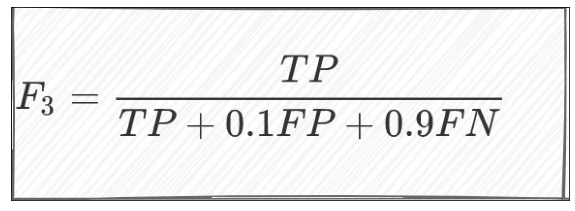

In [25]:
image = img.imread(r'C:\Users\Administrator\Desktop\projetprive\beta_3.jpeg')
plt.figure(figsize=(10,6))
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()

In [56]:
from sklearn import  metrics
from sklearn.metrics import roc_auc_score

### Calcul du fbeta_score  via make_scorer

In [57]:
from sklearn.metrics import fbeta_score, make_scorer

In [58]:
fthree_scorer = make_scorer(fbeta_score, beta=3)
fthree_scorer
make_scorer(fbeta_score, beta=3)

make_scorer(fbeta_score, beta=3)

### Balanced Random forest optimisation via GridSearchCV

In [64]:
params = {
    'n_estimators' : [1000], #nombre d'arbres de décision
    "min_samples_split" : [2,4],#nombres d'individus minimum pour que puisse avoir la séparation d'un noeud.
    'min_samples_leaf' : [1,3, 5], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'], #nombre de features observées pour chaque arbre
    'bootstrap': [True, False] #définit si chaque bootstrap se fait sur tout le jeu de donnée ou juste une partie.
   # "max_depth" : [20, 50, 80] #profondeur de chaque arbre
   
}

In [65]:
RandomForestmodel_search = GridSearchCV(BalancedRandomForestClassifier(n_jobs=-1, random_state=12),
                               param_grid = params,scoring=fthree_scorer,
                              verbose=2,
                               cv=5)

RandomForestmodel_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  56.8s
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.7s remaining:    0.0s


[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  50.8s
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  54.9s
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total= 1.0min
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  52.7s
[CV] bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=  53.2s
[CV] bootstrap=True, max_

[CV] bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total= 1.5min
[CV] bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total= 1.4min
[CV] bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total= 1.4min
[CV] bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total= 1.5min
[CV] bootstrap=True, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_features=sqrt,

[CV]  bootstrap=False, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=  56.9s
[CV] bootstrap=False, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=  57.1s
[CV] bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, total=  56.5s
[CV] bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, total=  58.1s
[CV] bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, total=  56.3s
[CV] bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000, total=  56.5s
[CV] bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000, total=  55.7s
[CV] bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000, total=  58.2s
[CV] bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=1000, total=  56.2s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 140.5min finished


GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(n_jobs=-1,
                                                      random_state=12),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4], 'n_estimators': [1000]},
             scoring=make_scorer(fbeta_score, beta=3), verbose=2)

In [66]:
best_random3 = RandomForestmodel_search.best_estimator_
best_random3 

BalancedRandomForestClassifier(bootstrap=False, min_samples_leaf=5,
                               n_estimators=1000, n_jobs=-1, random_state=12)

In [67]:
y_pred3 = best_random3.predict(X_test)
roc_auc_score(y_test, y_pred3)

0.6790845313877801

In [68]:
from collections import Counter
print("Counter y_pred3:" , Counter(y_pred3))

Before SMOTE : Counter({0.0: 19806, 1.0: 10194})


In [69]:
print("Counter y_test:" ,Counter(y_test))

Before SMOTE : Counter({0.0: 27549, 1.0: 2451})


<AxesSubplot:ylabel='count'>

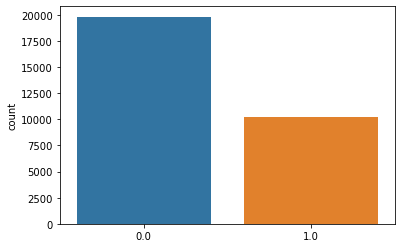

In [70]:
sns.countplot (y_pred3)

### Pickle du modèle optimisé:
- Ce modèle sera à la bade des prédictions dans le dashboard

In [71]:
import pickle

In [72]:
best_random3.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, min_samples_leaf=5,
                               n_estimators=1000, n_jobs=-1, random_state=12)

In [73]:
modelEssaiP77= 'finalized_model.sav'

In [74]:
pickle.dump(best_random3, open(modelEssaiP77,'wb'))

In [75]:
loaded_model = pickle.load(open(modelEssaiP77, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6877666666666666


### Feature importance global

In [76]:
# fonction pour créer un feature importance dataframe
def feature_importance(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [77]:
# fonction pour créer un plot de feature importance dataframe (horizontal barchart)
def feature_importance_plot(feature_importance_df, title):
    feature_importance_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = feature_importance_df.head(8), orient = 'h', color = 'royalblue').set_title(title, fontsize = 20)

In [78]:
base_importance = feature_importance(X_train.columns, best_random3.feature_importances_)
base_importance

,feature,feature_importance
0,EXT_SOURCE_3,8.336622e-02
1,EXT_SOURCE_2,7.862634e-02
2,PAYMENT_RATE,3.162600e-02
3,DAYS_BIRTH,2.966797e-02
4,EXT_SOURCE_1,2.965544e-02
5,DAYS_EMPLOYED,2.930434e-02
6,DAYS_EMPLOYED_PERC,2.637647e-02
7,DAYS_LAST_PHONE_CHANGE,2.593602e-02
8,DAYS_ID_PUBLISH,2.572391e-02
9,AMT_ANNUITY,2.383221e-02


In [79]:
coefficients = abs(best_random3.feature_importances_)
df_coefficients = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

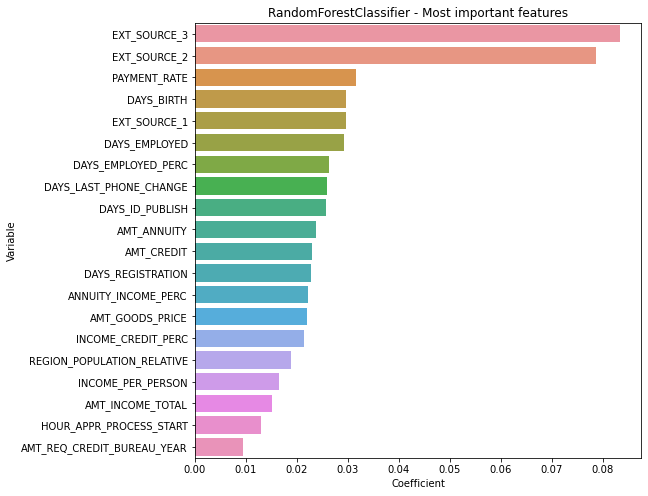

In [80]:
plt.figure(figsize=(8,8))
plt.title('RandomForestClassifier - Most important features')
sns.barplot(y = df_coefficients['Variable'].head(20), x = df_coefficients['Coefficient'].head(20))
plt.show()

### Fteature importance locale via la librairie Shap:
- Son interprétation permettra de comprendre  pourquoi un client donné est considéré comme bon ou mauvais prospect et quelles sont ses données / features qui expliquent son évaluation. 

In [81]:
from interpret import show
from interpret.blackbox import ShapKernel

In [82]:
import shap

In [83]:
shap = ShapKernel(predict_fn=best_random3.predict_proba, data=X_train.sample(200))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [84]:
shap_local = shap.explain_local(X_test[:5], y_test[:5])

show(shap_local)

<!-- http://127.0.0.1:7467/2500068880880/ -->